In [12]:
from database_connection import connect_to_db, close_db_connection
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

Sales trends over time

Definition: Show how sales evolve over a specific time period.

Visualisation: Stacked bar chart showing daily/weekly/monthly sales trends.

Example KPI:"Daily sales trend for Q1 2023."

- requirements - total units sold (revenue) over time.
- tables - fact_sales_order

In [13]:
def fetch_sales_trends_data(conn, interval='day', start_date=None, end_date=None):
    """Fetch sales trends grouped by a specific interval"""

    # Base SQL query
    query = f"""
        SELECT
            DATE_TRUNC('{interval}', so.created_date) AS sales_date,
            SUM(so.units_sold) AS total_units_sold,
            SUM(so.units_sold * so.unit_price) AS total_revenue
        FROM
            fact_sales_order so
    """

    # Add date filtering if start_date and end_date are provided
    if start_date and end_date:
        query += f"""
        WHERE
            so.created_date >= '{start_date}'
            AND so.created_date <= '{end_date}'
        """
    
    # Add grouping and ordering
    query += """
        GROUP BY
            sales_date
        ORDER BY
            sales_date;
    """
    
    # Execute the query and fetch the results
    cursor = conn.cursor()
    cursor.execute(query)
    columns = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()
    cursor.close()
    
    # Convert the result into a Pandas DataFrame
    return pd.DataFrame(rows, columns=columns)

In [44]:
def visualize_stacked_sales_trends(data, metric, file_name):
    """Visualise sales trends using a stacked bar chart"""
    # Ensure sales_date is a datetime object
    data['sales_date'] = pd.to_datetime(data['sales_date'])
    data.sort_values('sales_date', inplace=True)
    # plot a stacked bar chart
    
    # Plot 1 - sales by total units sold
    plt.figure(figsize=(12, 6))
    plt.bar(
        data['sales_date'], data[metric], 
        color='skyblue' if metric =='total_units_sold' else 'cyan', 
        edgecolor='red' if metric =='total_units_sold' else 'black', 
        label=metric.replace("_", " ").capitalize()
    )
    plt.title(f"Sales Trends Over Time ({metric.replace('_', ' ').capitalize()})")
    plt.xlabel("Date")
    plt.ylabel("Sales (in millions)")
    plt.grid(axis='y')
    plt.legend()
    # Format y-axis in millions
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{(x / 1e6):.2f}M'))
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()
    plt.close()
   

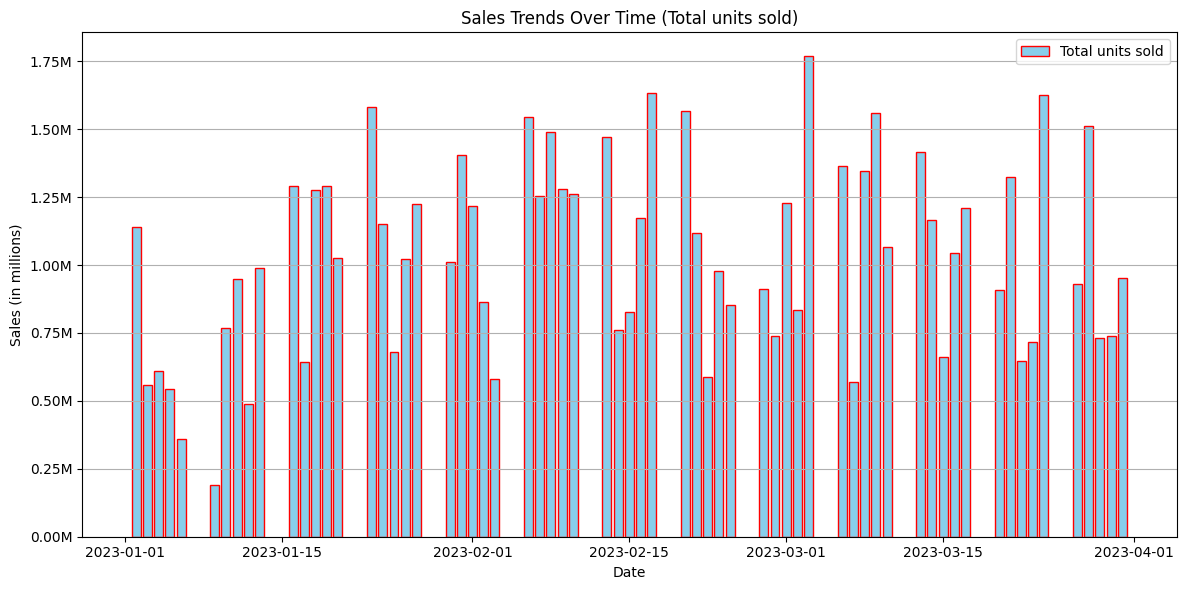

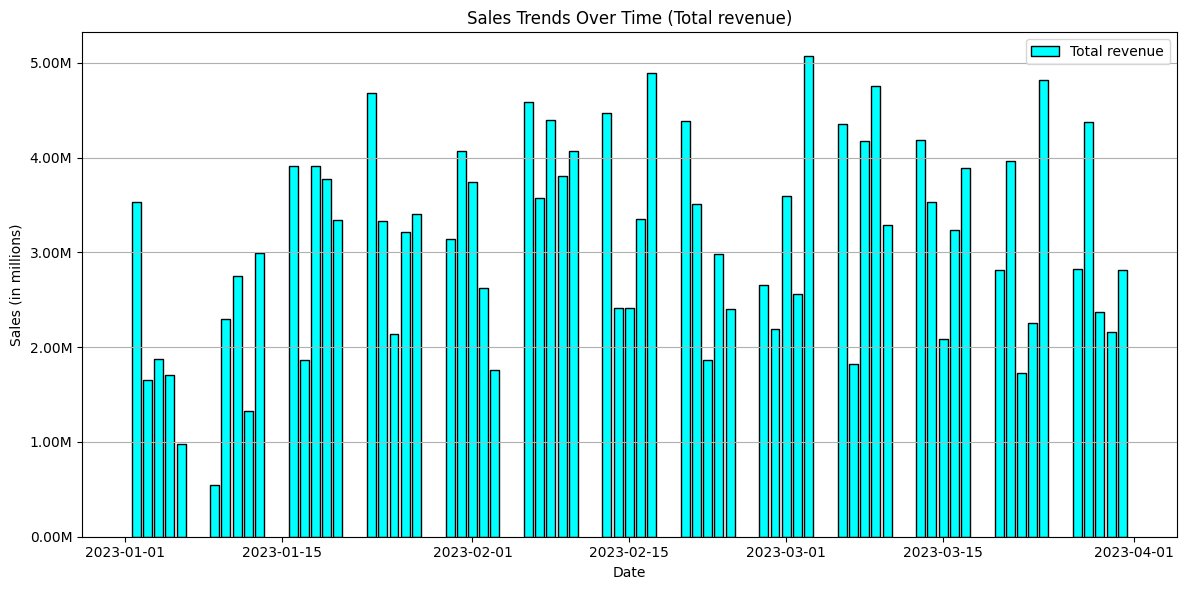

In [47]:
# Connect to the database
conn = connect_to_db()

# Fetch the data
start_date = "2023-01-01"
end_date = "2023-03-31"
sales_trends_data = fetch_sales_trends_data(conn, interval='day', start_date=start_date, end_date=end_date)

# Close the connection
conn.close()

# Visualize the data for total units sold
visualize_stacked_sales_trends(
    data=sales_trends_data,
    metric="total_units_sold",
    file_name="sales_trends_with_units_sold.png"
)

# Visualize the data for total revenue
visualize_stacked_sales_trends(
    data=sales_trends_data,
    metric="total_revenue",
    file_name="sales_trends_with_revenue.png"
)